# Real-Time Optimization
## Modifier Adaptation with Bayesian Optimization using EIC acquisition
### Different problem instances

In [1]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.utils import Bunch

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.basicConfig(level=logging.ERROR)

from rto.models.williams_otto import WilliamsOttoReactor_CamelHump, WilliamsOttoReactor_Branin, WilliamsOttoReactorSimplified_CamelHump, WilliamsOttoReactorSimplified_Branin
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform
from rto.experiment.analysis import ExperimentAnalyzer

DATABASE = "/mnt/d/rto_data/thesis-analysis-03.db"

## Problem Description
The Williams-Otto CSTR is a benchmark process for real-time optimization (RTO) systems. It consists in the following reactions:

$ A + B \rightarrow C $ (1) 

$ B + C \rightarrow P + E $ (2) 

$ C + P \rightarrow G $ (3) 

where A and B are raw materials, P is the desired product, E is the byproduct with added sales value, C is the complex intermediate without sale value, and G is the residual material. The reactor is fed by two reactant flow rates (Fa and Fb). The full set of mass balance equations can be found in [1], for example.

Each reaction has its rate $k$ defined as a function of the reactor temperature Tr:

$ k_1 = 1.6599\times10^6\exp(-6666.7/Tr) $

$ k_2 = 7.2177\times10^8\exp(-8333.3/Tr) $ 

$ k_3 = 2.6745\times10^{12}\exp(-11111/Tr) $


Fa assumes a fixed, therefore Fb and Tr are our manipulated (decision) variables, $u=[Fb, Tr]$. The optimization objective is finding a combination of these variables in order to maximize the profit when the system reaches steady-state operation:

$ \Phi(u) = 1043.38*Xp*(Fa+Fb)+20.92*Xe*(Fa+Fb) - 79.23*Fa - 118.34*Fb$

where $Xp$ and $Xe$ are the amount of P and E in steady-state operation, respectively. Besides steady-state operation, the following operational constraints are enforced:

$Fb \in [3,6]$

$Tr \in [70, 100]$

$Xa < 0.12$
 
$Xg < 0.08$

In practice, however, it is very unlikely to know the complete model of a given process. It can be in the form of parametrical and/or structural mismatch. Parametrical mismatch means we know the model structure, but its parameters are uncertain. Structural mismatch is the case where we the complete model equations are unknown, which usually happens when trying to model complex processes and have to apply simplifications to some of its behaviors. It is easy to see that if we try to optimize a process based on a uncertain model, we can produce sub-optimal or even unfeasible operating points. This is where RTO systems come to the rescue: they are specifically designed to handle model uncertainty and lead to process optimality under convergence.

For the Williams-Otto CSTR we know all the process equations and parameters. Therefore, to study the real-time optimization capabilities, we will use a simplified version of this model in order to simulate what would happen in real applications. For that, we consider the following model structure:

$ A + 2B \rightarrow P + E $ (1) 

$ A + B + P \rightarrow G $ (2) 

And the reaction rates are given by:

$ k_1 = 1.655\times10^8\exp(-8077.6/Tr) $

$ k_2 = 2.611\times10^{13}\exp(-12438.5/Tr) $ 


## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [2]:
camelhump_plant = WilliamsOttoReactor_CamelHump()
branin_plant = WilliamsOttoReactor_Branin()

camelhump_model = WilliamsOttoReactorSimplified_CamelHump()
branin_model = WilliamsOttoReactorSimplified_Branin()

g_branin = np.array([0.16, 0.12])
g_camelhump = np.array([0.16, 0.12])
ubx = [5.5, 90]
lbx = [2.5, 70]

optimizer_branin = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g_branin)
optimizer_camelhump = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g_camelhump)

f_branin, u_branin ,_ = optimizer_branin.run(branin_plant, [])
f_camelhump, u_camelhump ,_ = optimizer_camelhump.run(camelhump_plant, [])

f_branin_model, u_branin_model ,_ = optimizer_branin.run(branin_model, [])
f_camelhump_model, u_camelhump_model ,_ = optimizer_camelhump.run(camelhump_model, [])

print(f'Branin: u*={u_branin}, f*={f_branin}')
print(f'Camel Hump: u*={u_camelhump}, f*={f_camelhump}')

print(f'Branin (model): u*={u_branin_model}, f*={f_branin_model}')
print(f'Camel Hump (model): u*={u_camelhump_model}, f*={f_camelhump_model}')

Branin: u*=[ 4.38310431 70.83576698], f*=1.922149599938562
Camel Hump: u*=[ 5.49981068 70.00498786], f*=-7.488332559679123
Branin (model): u*=[ 4.73734768 85.91956638], f*=0.3980821651164401
Camel Hump (model): u*=[ 5.49984244 70.01695753], f*=-26.66691856294007


Next, let's have a look at the decision surface of our cost function, along with the constraints. This is a way to observe the effects of the plant-model mismatch. First we do a grid search over the input domain, storing the objective and constraint values.

In [3]:
# Define the input domain
grid_size = 50

u1 = np.linspace(2.5, 6, grid_size)
u2 = np.linspace(70, 100, grid_size)
xx, yy = np.meshgrid(u1, u2)

def get_grid_values(model, xx, yy, noise=None):
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x, noise) for x in grid])
    g = np.array([model.get_constraints(x, noise) for x in grid])
    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    # zz_g0 = g[:,0].reshape(xx.shape)
    # zz_g1 = g[:,1].reshape(xx.shape)
    zz_g = [g[:,i].reshape(xx.shape) for i in range(g.shape[1])]
    return zz_cost, *zz_g

def plot_decision_surface(fig, ax, xx, yy, z_f, z_c, title, contour_type='contourf'):
    if(z_f is not None):
        ax.contour(xx, yy, z_f, colors='red')

    if(contour_type=='contourf'):
        CS = ax.contourf(xx, yy, z_c, cmap='viridis')
    else:
        CS = ax.contour(xx, yy, z_c, cmap='viridis')
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

Now, the contour plot is generated for both the plant and model. The feasible region is limited by the red surface.

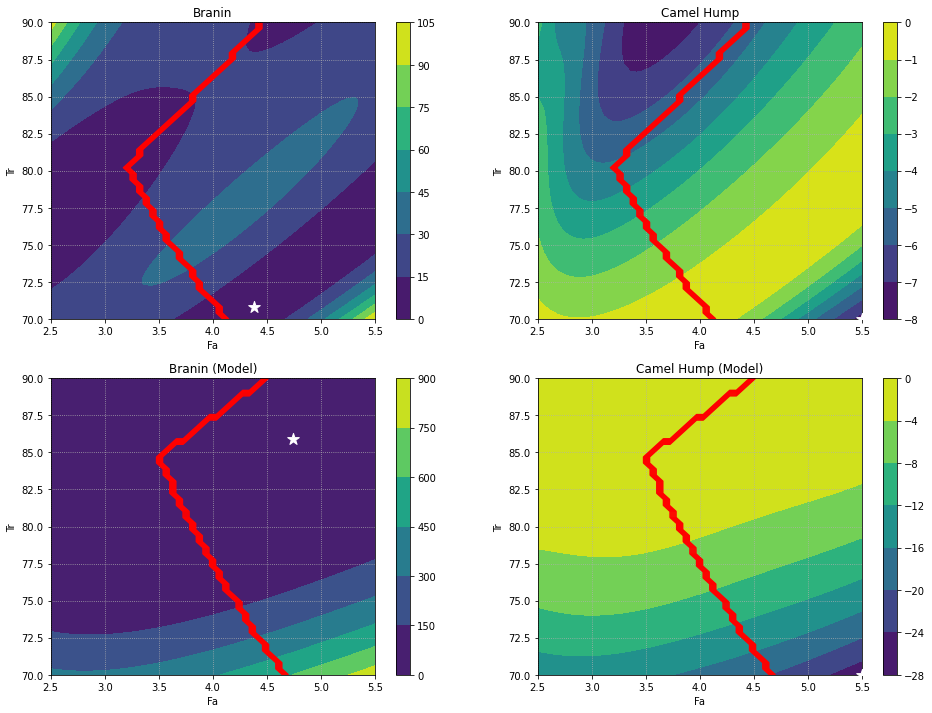

In [4]:
fig, ax = plt.subplots(2,2,figsize=(16,12))

u1 = np.linspace(2.5, 5.5, grid_size)
u2 = np.linspace(70, 90, grid_size)
xx, yy = np.meshgrid(u1, u2)

# generate plant surface data
z_branin, g0_branin, g1_branin = get_grid_values(branin_plant, xx, yy)
z_camelhump, g0_camelhump, g1_camelhump = get_grid_values(camelhump_plant, xx, yy)
g_plant_branin = (g0_branin < g_branin[0])&(g1_branin < g_branin[1])
g_plant_camelhump = (g0_camelhump < g_camelhump[0])&(g1_camelhump < g_camelhump[1])

# generate model surface data
z_branin_model, g0_branin_model, g1_branin_model = get_grid_values(branin_model, xx, yy)
z_camelhump_model, g0_camelhump_model, g1_camelhump_model = get_grid_values(camelhump_model, xx, yy)
g_model_branin = (g0_branin_model < g_branin[0])&(g1_branin_model < g_branin[1])
g_model_camelhump = (g0_camelhump_model < g_camelhump[0])&(g1_camelhump_model < g_camelhump[1])

plot_decision_surface(fig, ax[0,0], xx, yy, g_plant_branin, z_branin, 'Branin')
plot_decision_surface(fig, ax[0,1], xx, yy, g_plant_camelhump, z_camelhump, 'Camel Hump')

plot_decision_surface(fig, ax[1,0], xx, yy, g_model_branin, z_branin_model, 'Branin (Model)')
plot_decision_surface(fig, ax[1,1], xx, yy, g_model_camelhump, z_camelhump_model, 'Camel Hump (Model)')

ax[0,0].scatter(u_branin[0], u_branin[1], c='w', marker='*', s=150, zorder=5)
ax[0,1].scatter(u_camelhump[0], u_camelhump[1], c='w', marker='*', s=150, zorder=5)
ax[1,0].scatter(u_branin_model[0], u_branin_model[1], c='w', marker='*', s=150, zorder=5)
ax[1,1].scatter(u_camelhump_model[0], u_camelhump_model[1], c='w', marker='*', s=150, zorder=5)

fig.show()

From this chart we notice these interesting information:
1. The unconstrained minima of plant and model and very different. Optimizing over the model would definitely result in a sub-optimal operating point.
2. When constraints are added, the optima are located at their intersection. This could lead to unfeasible operation if optimazing over the model, if not properly evaluated beforehand.

Let's have a deeper look at item (2). In order to do that, we should solve the optimization problem described previously, for both the plant and model. The Differential Evolution algorithm will be used, because of it's nice capabilities for handling restrictions and global convergence.

Although the solution found for both the model and plant are very close, let's see what happens if we apply the input found with the model into the plant. The 'x' represents the model solution, while the "*" the plant optimum.

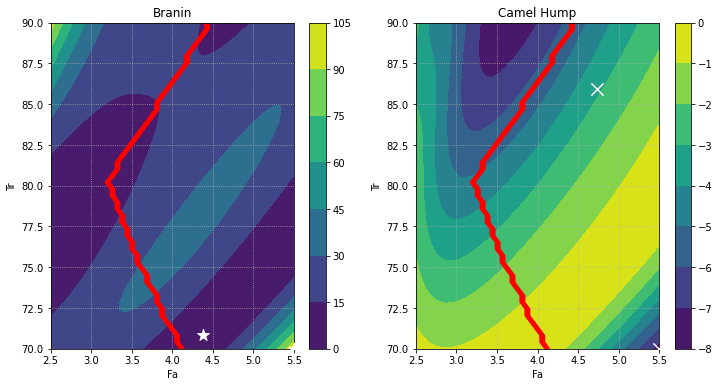

In [5]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
plot_decision_surface(fig, ax[0], xx, yy, g_plant_branin, z_branin, 'Branin')
plot_decision_surface(fig, ax[1], xx, yy, g_plant_camelhump, z_camelhump, 'Camel Hump')

ax[0].scatter(u_branin[0], u_branin[1], c='w', marker='*', s=150, zorder=5)
ax[0].scatter(u_camelhump[0], u_camelhump[1], c='w', marker='*', s=150, zorder=5)
ax[1].scatter(u_branin_model[0], u_branin_model[1], c='w', marker='x', s=150, zorder=5)
ax[1].scatter(u_camelhump_model[0], u_camelhump_model[1], c='w', marker='x', s=150, zorder=5)

fig.show()

Notice that although the solution remained inside the feasible region, it is definitely sub-optimal. It is easy to notice that depending on the model parameters, the optimal solution could easily become unfeasible. Thus, one can see that some sort of adaptation of the model is necessary to ensure convergence to the actual plant optimum, while respecting the process constraints. 

## Real-Time Optimization

RTO systems are capable of iteratively driving the system towards the optimum in spite of plant-model mismatch. The entire system is displayed in the image below:

![RTO System](rto_diagram.png)

Several approaches exist in the literature, and can be classified based on the adaptation strategy they use. The most relevant are the two-step (TS) and modifier adaptation (MA). TS employs as adaptation strategy the update of the model parameters by solving a data reconciliation problem based on measured plant data. On the other hand, modifier adaptation uses plant data to add the so-called modifiers to the cost and constraint functions of the model-based optimization problem. Each method has its pros and cons, and their usage will depend on the process being optimized. 
Here I am going to use first the Modifier Adaptation with Gaussian Processes (GP) scheme.

### Modifier Adaptation with Gaussian Processes
This is a novel technique that leverages GP regression to represent the plant-model mismatch. It removes the need of calculating plant gradients, a requirement for previous MA schemes. The diagram below display how it works in practice:

![MA-GP](rto_magp_diagram.png)

The RTO system is run with the following parameters:
* 5 random feasible sub-optimal operating points
* 30 RTO iterations
* Plant measurements without any noise
* GP regression:
  * Squared-exponential kernel
  * Trained using the last 10 available operating points
  * New data is only incorporated if sufficiently far from the existing data
* Input exponential filter: $\eta = 0.4$

This experiment is repeated 10 times, given the stochastic nature of the RTO system.

Since we know the plant's optimal cost and input signal, we can evalute the system performance based on the relative optimality gap:

$\Delta u\% =  \left\|100 \frac{u - u^{opt}}{u^{opt}} \right\|, \quad \Delta \phi \% =  100 \frac{\phi - \phi^{opt}}{\phi^{opt}} $

In [6]:
def plot_convergence_comparison_surface(results_1, results_2, g_plant, z_plant, u_plant, title, legend, initial_data_size=5):
    fig, ax = plt.subplots(figsize=(8,6))

    plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, title)
    u_rto_1 = np.stack(results_1['u'], axis=0)
    u_rto_2 = np.stack(results_2['u'], axis=0)

    u_rto_init = u_rto_1[:initial_data_size, :]
    u_rto_1 = u_rto_1[initial_data_size:, :]
    u_rto_2 = u_rto_2[initial_data_size:, :]

    ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)
    ax.plot(u_rto_init[:,0], u_rto_init[:,1], 'md', zorder=4)
    line1, = ax.plot(u_rto_1[:,0], u_rto_1[:,1], 'ko-', zorder=4)
    line2, = ax.plot(u_rto_2[:,0], u_rto_2[:,1], 'b.-', zorder=5)
    ax.legend((line1, line2), legend)

    fig.show()

## EIC acquisition function

There is a clear link between RTO and Bayesian optimization. Both problems try to optimize and unknown and expensive-to-evaluate function by sampling it according to some heuristics. The main difference lies in the fact that the Bayesian framework is purely data-drive, while in RTO we have a model that, although imperfect, captures the main behavior of the unknown function. Notice that this works as some sort of *prior* knowledge, which in the Bayesian frameork could be historical samples of the function to be optimized, for example.

Considering the MA-GP scheme, one can see that the RTO system learns the plant-model mismatch using GPs and the prior knowledge of the model is used to drive plant optimization. In the Bayesian framework, this is achieved with the use of so-called acquisition functions. Therefore, one could ask the following question: what if we included the acquisition function in RTO procedure? Could this improve the system's performance? 

This was already done by [XX], which applied an EI acquisition to the objective, but used derivative-free and trust-region concepts to handle constrained problems. The idea behind this is to reduce or increase the trust-region size based on thje discrepancy between model estimations and plant measurements. But, one can clearly see that embedding a fully constrained Bayesian framework could be easily achieved. We can change the model-based optimization problem to use the EIC acquisition function, since we have GPs already trained on the constraints mismatch. This turns our constrained problem into a unconstrained one, using a barrier-like objective function.

First, let's run the optimization problem with the EIC acquisition function, using the same default parameters for GP learning. We also run MA-GP as a baseline to compare the results. The last sampled initial operating point is used to start the system. For now, only the noiseless case is considered, to avoid unexpected effects.

### Optimizer Choice

In [7]:
# load the results
analyzer = ExperimentAnalyzer(DATABASE)

results_bay_de_branin = analyzer.load('MA-GP-Bayesian-DE-branin')
results_bay_sqp_branin = analyzer.load('MA-GP-Bayesian-SQP-branin')
results_bay_de_camelhump = analyzer.load('MA-GP-Bayesian-DE-camelhump')
results_bay_sqp_camelhump = analyzer.load('MA-GP-Bayesian-SQP-camelhump')

# pre-process results
results_processed_bay_de_branin = analyzer.pre_process(results_bay_de_branin, f_branin, u_branin)
results_processed_bay_sqp_branin = analyzer.pre_process(results_bay_sqp_branin, f_branin, u_branin)
results_processed_bay_de_camelhump = analyzer.pre_process(results_bay_de_camelhump, f_camelhump, u_camelhump)
results_processed_bay_sqp_camelhump = analyzer.pre_process(results_bay_sqp_camelhump, f_camelhump, u_camelhump)

# join results
results_bayes_camelhump = pd.concat([results_processed_bay_de_camelhump, results_processed_bay_sqp_camelhump], ignore_index=True)
results_bayes_branin = pd.concat([results_processed_bay_de_branin, results_processed_bay_sqp_branin], ignore_index=True)

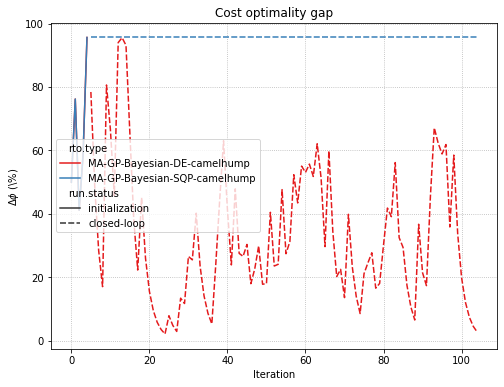

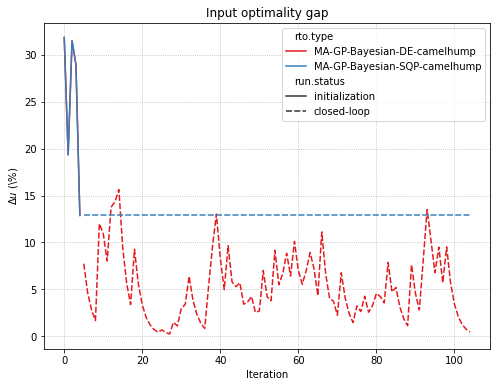

In [8]:
_ = analyzer.plot_by_iteration(results_bayes_camelhump, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_camelhump, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

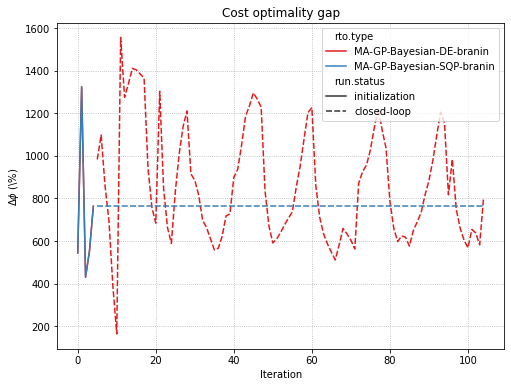

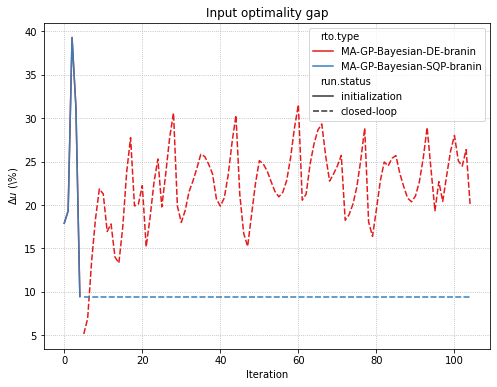

In [9]:
_ = analyzer.plot_by_iteration(results_bayes_branin, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_branin, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

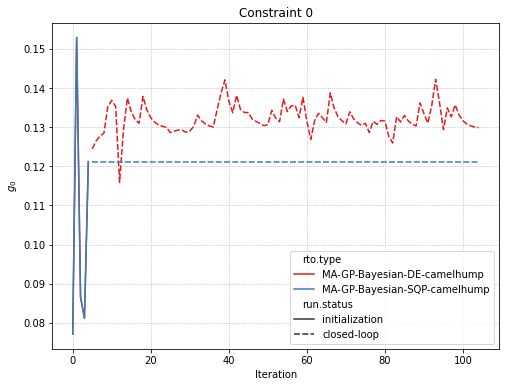

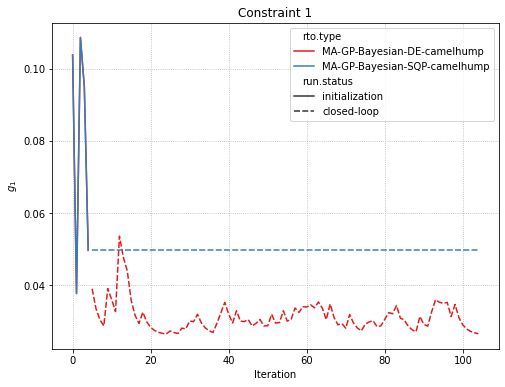

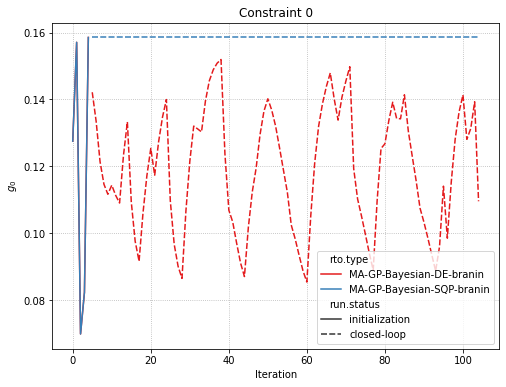

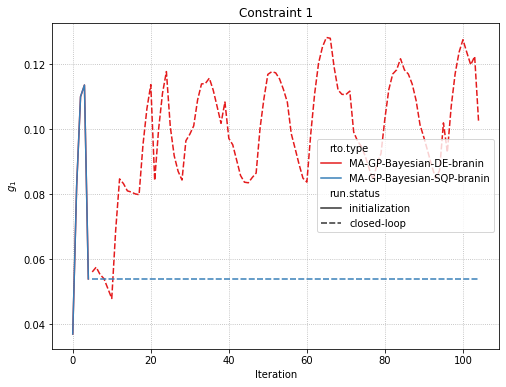

In [10]:
_ = analyzer.plot_by_iteration(results_bayes_camelhump, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_camelhump, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

_ = analyzer.plot_by_iteration(results_bayes_branin, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_branin, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

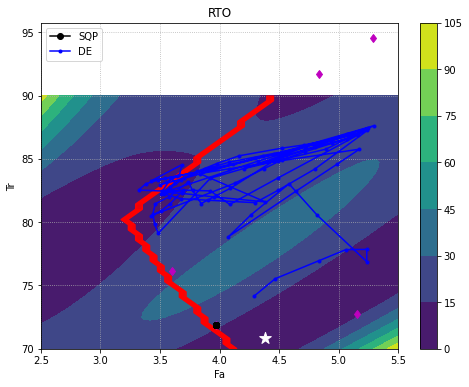

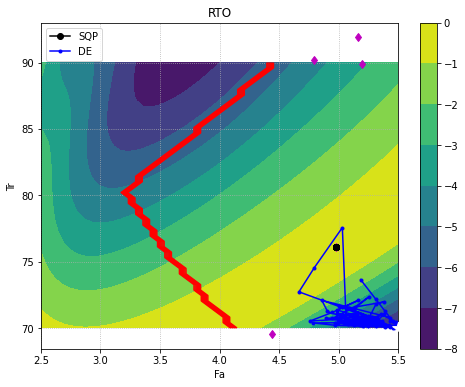

In [13]:
plot_convergence_comparison_surface(results_processed_bay_sqp_branin, results_processed_bay_de_branin, g_plant_branin, z_branin, u_branin, 'RTO', ('SQP','DE'))
plot_convergence_comparison_surface(results_processed_bay_sqp_camelhump, results_processed_bay_de_camelhump, g_plant_camelhump, z_camelhump, u_camelhump, 'RTO', ('SQP','DE'))

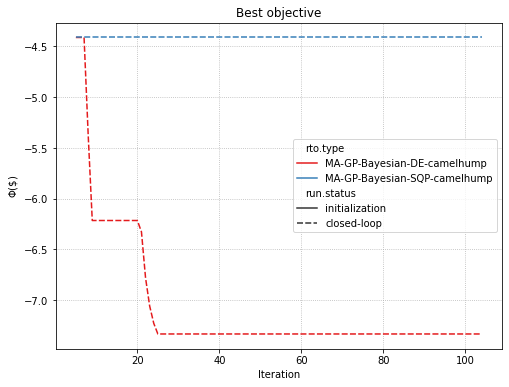

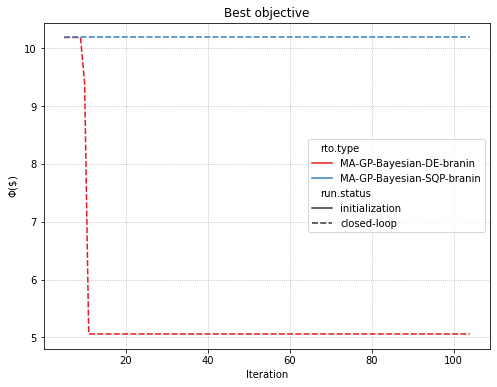

In [12]:
_ = analyzer.plot_by_iteration(results_bayes_camelhump, 'best_plant_objective', '$\Phi (\$)$', 'Best objective',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_branin, 'best_plant_objective', '$\Phi (\$)$', 'Best objective',style='run.status', hue='rto.type')

### MA-GP comparison

In [17]:
results_bay_de_branin = analyzer.load('MA-GP-Bayesian-DE-branin+noise-datasets')
#results_magp_de_branin = analyzer.load('MA-GP-DE-branin')
results_bay_de_camelhump = analyzer.load('MA-GP-Bayesian-DE-camelhump+noise-datasets')
#results_magp_de_camelhump = analyzer.load('MA-GP-DE-camelhump')

# pre-process results
results_processed_bay_de_branin = analyzer.pre_process(results_bay_de_branin, f_branin, u_branin)
#results_processed_magp_de_branin = analyzer.pre_process(results_magp_de_branin, f_branin, u_branin)
results_processed_bay_de_camelhump = analyzer.pre_process(results_bay_de_camelhump, f_camelhump, u_camelhump)
#results_processed_magp_de_camelhump = analyzer.pre_process(results_magp_de_camelhump, f_camelhump, u_camelhump)

# join results
results_bayes_camelhump = pd.concat([results_processed_bay_de_camelhump], ignore_index=True)
results_bayes_branin = pd.concat([results_processed_bay_de_branin], ignore_index=True)

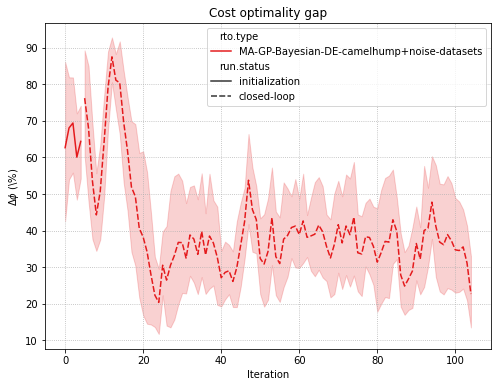

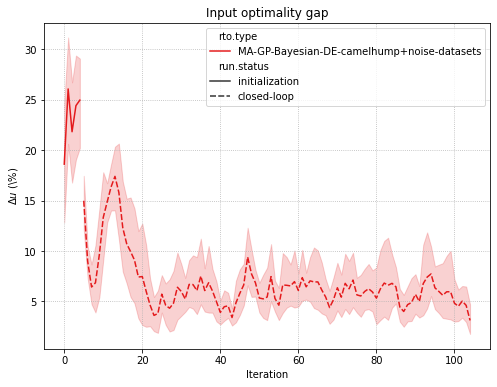

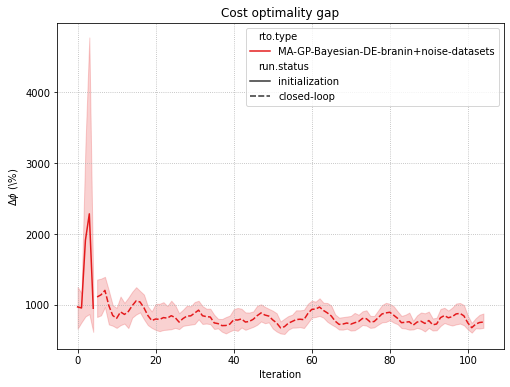

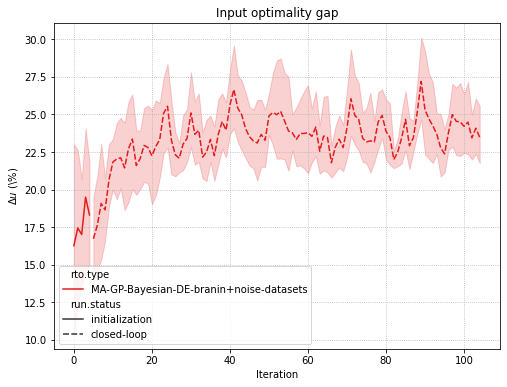

In [19]:
_ = analyzer.plot_by_iteration(results_bayes_camelhump, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_camelhump, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

_ = analyzer.plot_by_iteration(results_bayes_branin, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_branin, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

## Conclusion